# Miniproject-DQN Notebook
### Paul Boulenger, Paul Devianne

## Part 1: Introduction


In [3]:
#We import all necessary packages
import sys

import matplotlib.pyplot as plt
from gym import spaces

"""Environment imports"""
from epidemic_env.env       import Env, Log
from epidemic_env.dynamics  import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent     import Agent

"""Pytorch and numpy imports"""
import numpy as np
import torch
from torch import nn


from tqdm import tqdm
%load_ext autoreload
%autoreload 2
%matplotlib inline


### Question 1.a

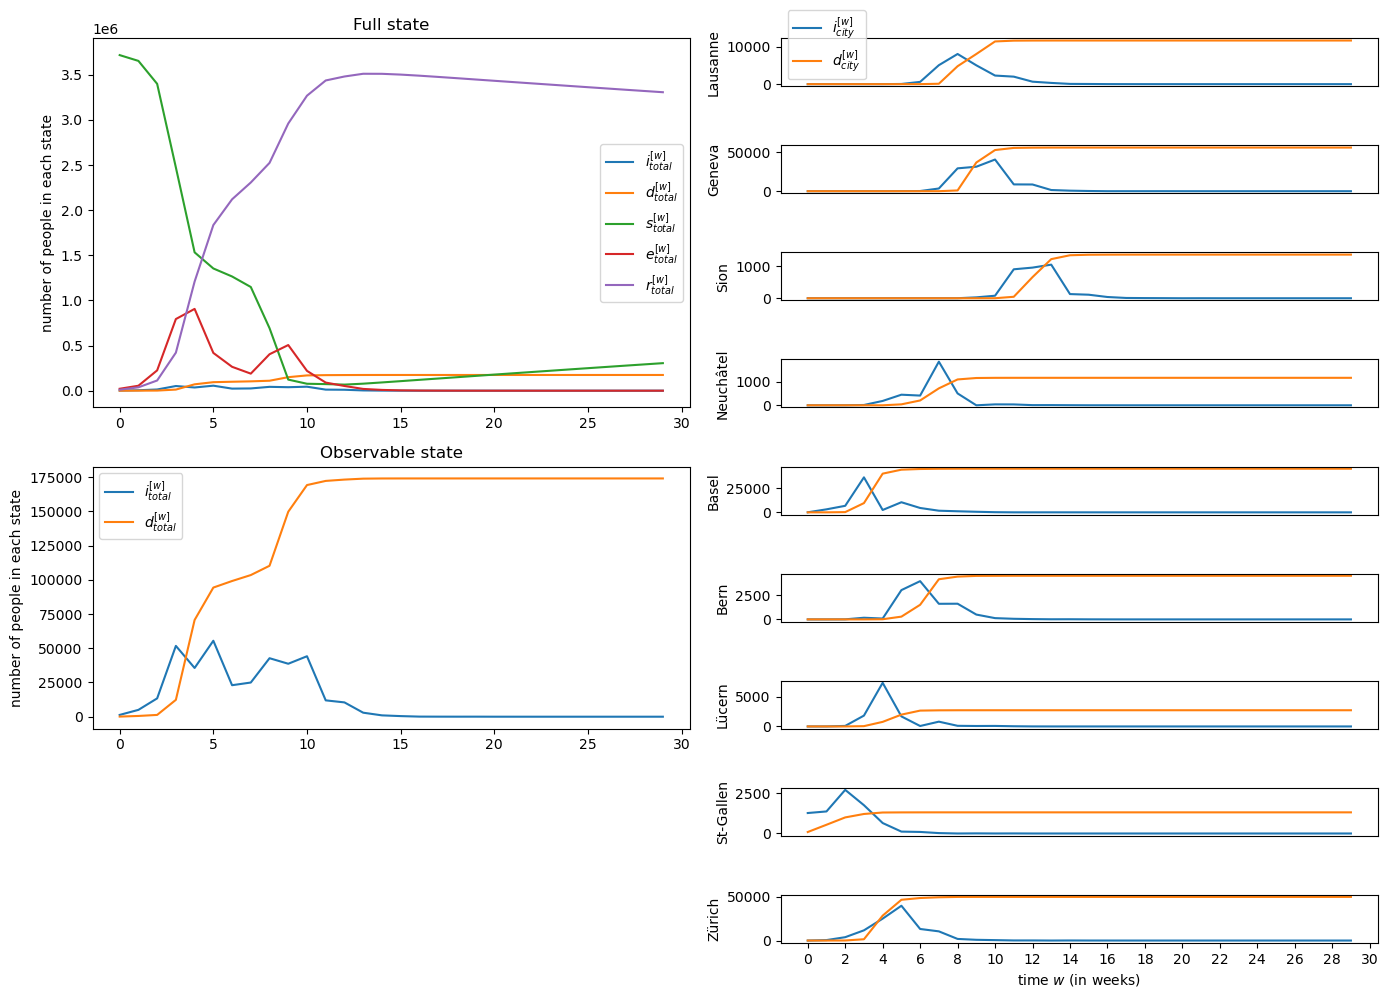

In [4]:
from utils import run_episode, action_preprocessor, run_episode, plot_episode
from utils import NoAgent

"""Loading the environment"""
dyn = ModelDynamics('config/switzerland.yaml')

env = Env(dyn,
            action_preprocessor=action_preprocessor)

no_agent = NoAgent(env) #Agent that takes no action

log , _ = run_episode(no_agent, env)

plot_episode(log, dyn)

## Part 2: Professor Russo's Policy

In [5]:
from epidemic_env.agent import RussoAgent

In [6]:
def observation_preprocessor_Russo(obs: Observation, dyn:ModelDynamics):
    infected=np.array([np.array(obs.city[c].infected) for c in dyn.cities])[:,6].sum() #only need to observe the number of infected
    return infected

In [6]:
dyn = ModelDynamics('config/switzerland.yaml')
env = Env(dyn,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor_Russo)

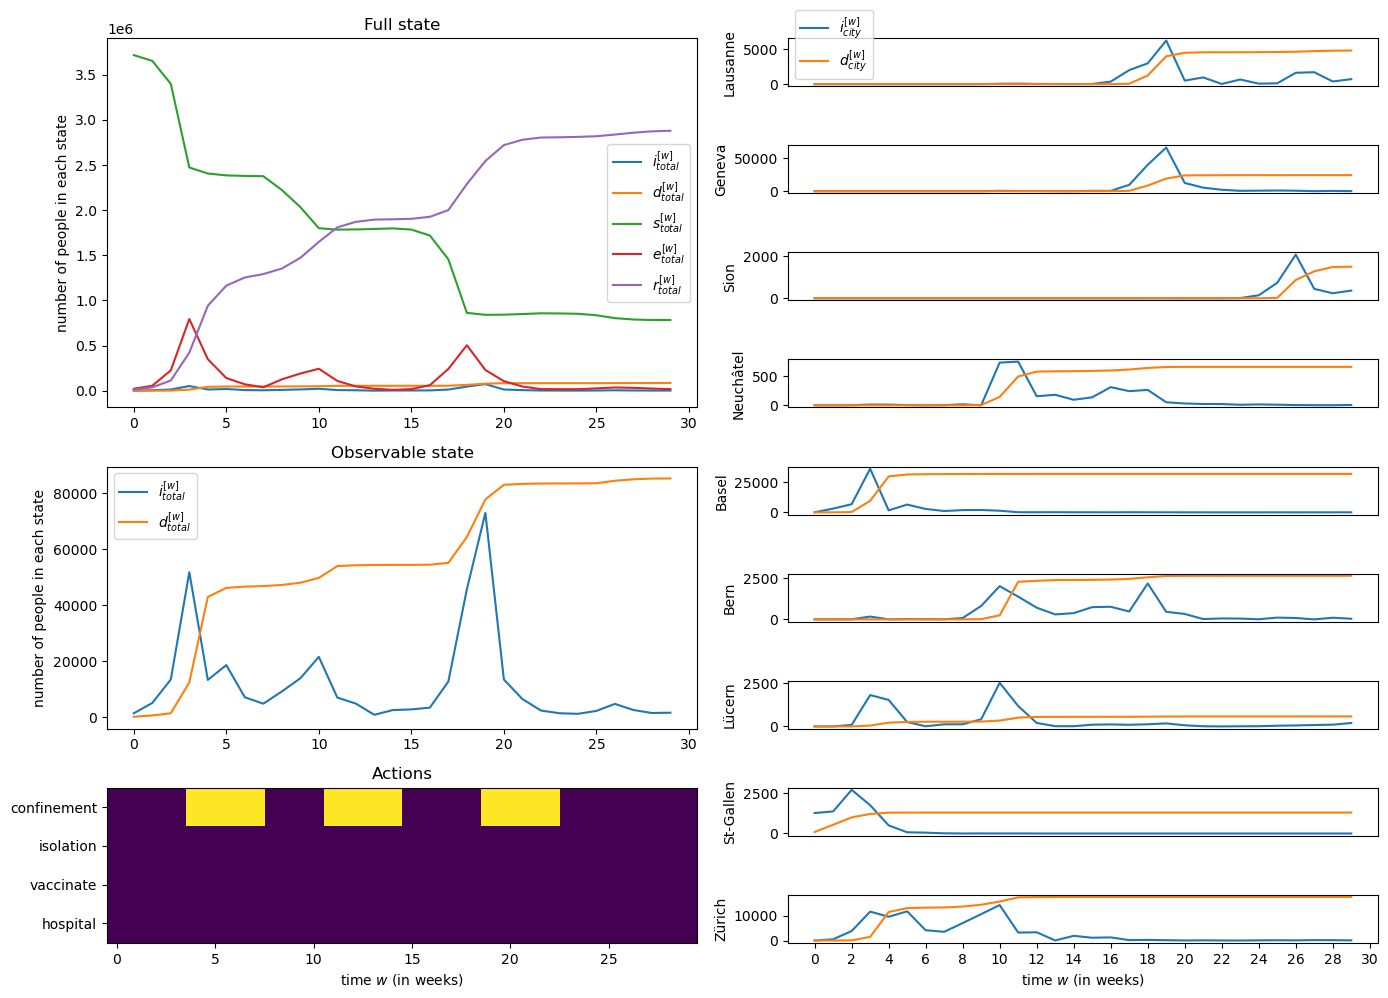

In [7]:
obs, info = env.reset(0)
agent = RussoAgent(env)

log, _ = run_episode(agent, env)
plot_episode(log, dyn, True)

## Part 3: A Deep Q-learning approach

#### Question 3.a

##### Training

In [24]:
from DQN import *
action_space=spaces.Discrete(2)
dyn = ModelDynamics('config/switzerland.yaml')
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)


env = Env(dyn,
            action_space = action_space,
            observation_space= observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor_DQN)

DQNagents = [DQNAgent(env) for _ in range(3)] #three agents
training_traces = []
eval_traces = []

for i,DQNag in enumerate(DQNagents) : #three training processes
    training_trace, eval_trace  = training_loop(env, DQNag, savepath= f"models/DQNparam{i+1}" ,first_seed= (i+1)*1000)
    training_traces.append(training_trace)
    eval_traces.append(eval_trace)


  0%|          | 0/500 [00:02<?, ?it/s]


KeyboardInterrupt: 

##### Plotting

In [25]:

colors = ['red', 'blue', 'green'] 
markers = ['o', 's', 'D'] 

x = list(range(len(training_traces[0]))) 
fig, ax = plt.subplots()

for i, training_trace in enumerate(training_traces):
    if i == 1 :
        y = training_trace 
        ax.scatter(x, y, color=colors[i], label=f'Training {i+1}')

ax.legend() 
ax.set_xlabel('Training steps')
ax.set_ylabel('Rewards')
plt.show()


avg_eval_trace = np.mean(np.array(eval_traces), axis=1)
plt.plot(avg_eval_trace)
ax.set_xlabel('Training steps')
ax.set_ylabel('Average evaluation rewards')
plt.show()


IndexError: list index out of range

##### Looking at the policy

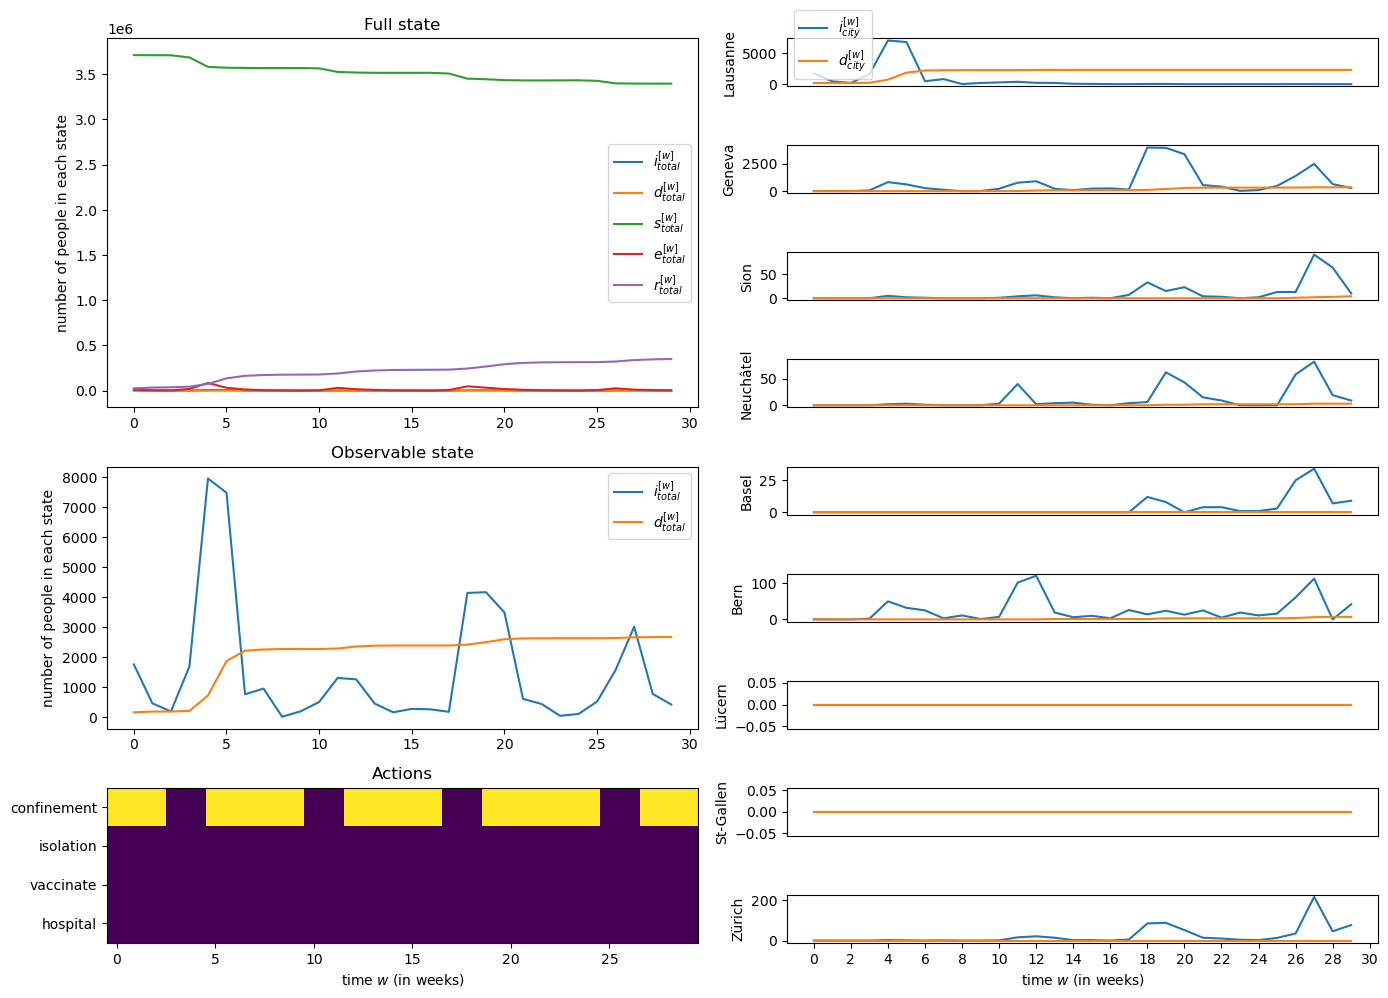

In [27]:
best_evals = np.max(eval_traces, 1)
best_agent = np.argmax(best_evals)
print(f"The best agent is the {best_agent +1}th one")


three_episodes = [run_episode(DQNagents[best_agent], env, 100*i) for i in range(3)]
plot_episode(three_episodes[2][0], dyn, True)

#### Question 3.b

In [32]:
from DQN import *
action_space=spaces.Discrete(2)
dyn = ModelDynamics('config/switzerland.yaml')
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)


env = Env(dyn,
            action_space = action_space,
            observation_space= observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor_DQN)

DQNdecay_agents = [DQNAgent(env, ) for _ in range(3)] #three agents
training_traces = []
eval_traces = []

for i,DQNag in enumerate(DQNagents) : #three training processes
    training_trace, eval_trace  = training_loop(env, DQNag, savepath= f"models/DQNparam{i+1}" ,first_seed= (i+1)*1000)
    training_traces.append(training_trace)
    eval_traces.append(eval_trace)




  0%|          | 0/500 [00:00<?, ?it/s]

Unexpected exception formatting exception. Falling back to standard exception



Traceback (most recent call last):
  File "/Users/paul/anaconda3/envs/epi/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/27/gzfnj9yd3k9cqcsd_5z6mx3m0000gn/T/ipykernel_9837/3370290730.py", line 18, in <module>
    training_trace, eval_trace = training_loop(env, DQNAgent)
  File "/Users/paul/Desktop/Miniproject-ANN/DQN.py", line 225, in training_loop
    _, rwds = training_episode(env, DQNagent, update_target=(i%C ==0 ), seed =  i)
NameError: name 'C' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/paul/anaconda3/envs/epi/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2102, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/Users/paul/anaconda3/envs/epi/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1310, in structured_traceback

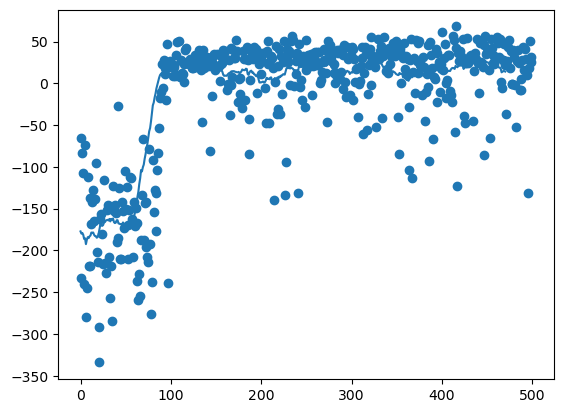

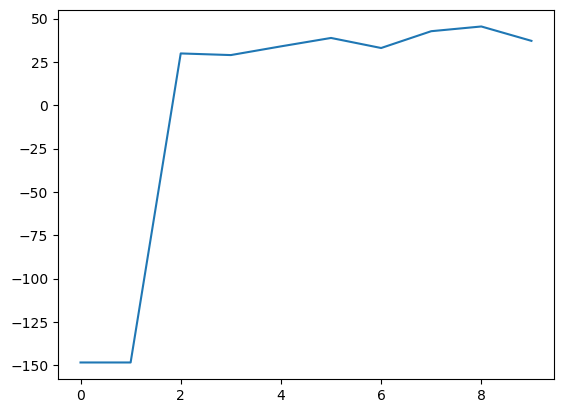

In [30]:
window_size = 30  # Adjust the window size as needed
moving_avg = np.convolve(training_trace, np.ones(window_size) / window_size, mode='valid')

plt.scatter(range(len(training_trace)), training_trace)
plt.plot(moving_avg)
plt.show()


plt.plot(eval_trace)
plt.show()


#### Question 3.c 

## Part4: Dealing with a more complex action Space

In [50]:
toggle_action_space = action_space=spaces.Discrete(5)
toggle_observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(6, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)

def toggle_observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])**(1/4)
    dead = SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])**(1/4)
    confined = np.ones_like(dead)*int((dyn.get_action()['confinement']))
    isolated = np.ones_like(dead)*int((dyn.get_action()['isolation']))
    beds_added = np.ones_like(dead)*int((dyn.get_action()['hospital']))
    vaccinated = np.ones_like(dead)*int((dyn.get_action()['vaccinate']))
    return torch.Tensor(np.stack((infected, dead, confined, isolated, beds_added,vaccinated))).unsqueeze(0)

ACTION_NULL = 0
ACTION_CONFINE = 1
ACTION_ISOLATE = 2
ACTION_HOSPITAL = 3
ACTION_VACCINATE = 4

def toggle_action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    action = dyn.get_action()

    if a == ACTION_CONFINE:
        action['confinement'] = not action['confinement']
    elif a == ACTION_ISOLATE:
        action['isolation'] = not action['isolation']
    elif a == ACTION_VACCINATE:
        action['vaccinate'] = not action['vaccinate']
    elif a == ACTION_HOSPITAL:
        action['hospital'] = not action['hospital']
        
    return action

env = Env(dyn,
            action_space = toggle_action_space,
            observation_space= toggle_observation_space,
            action_preprocessor= toggle_action_preprocessor,
            observation_preprocessor= toggle_observation_preprocessor)

DQNagent  = DQNAgent(env, lr = 10e-5 ,eps_min= 0.2, Tmax= 500)
training_trace, eval_trace  = training_loop(env, DQNagent, first_seed= 1000)


100%|██████████| 500/500 [20:59<00:00,  2.52s/it]  


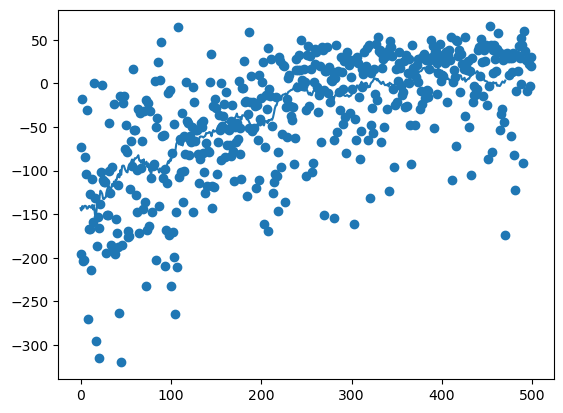

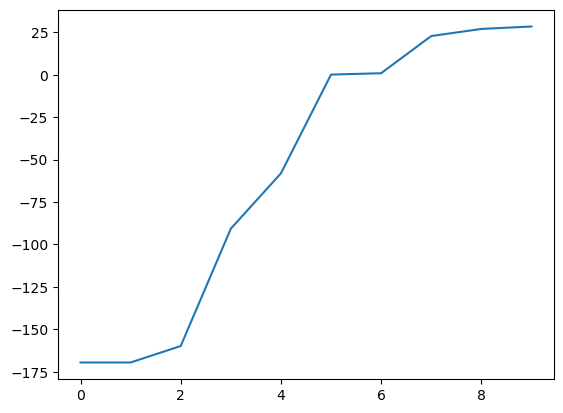

In [51]:
window_size = 30  # Adjust the window size as needed
moving_avg = np.convolve(training_trace, np.ones(window_size) / window_size, mode='valid')

plt.scatter(range(len(training_trace)), training_trace)
plt.plot(moving_avg)
plt.show()


plt.plot(eval_trace)
plt.show()

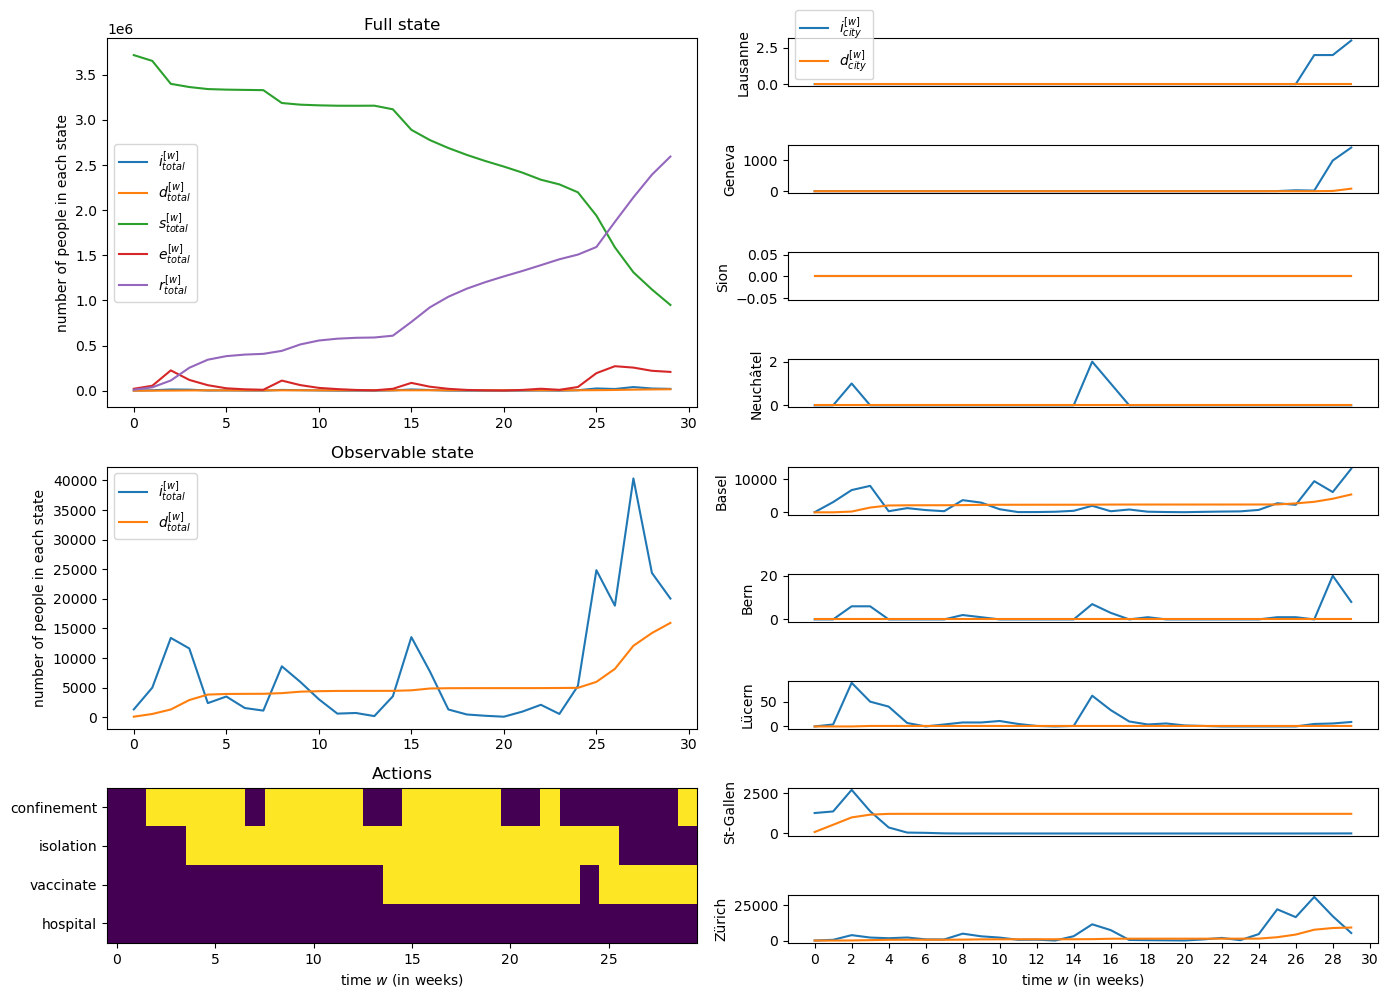

In [49]:
#three_episodes = [run_episode(DQNagent, env, 100*i) for i in range(3)]
plot_episode(three_episodes[0][0], dyn, True)

## Part5: Wrapping Up